# Processing ERA5 data with Dask & AWS Fargate

This notebook demonstrates how to work with the ECMWF ERA5 reanalysis available as part of the AWS Public Dataset Program (https://registry.opendata.aws/ecmwf-era5/).

## Python Imports

In [1]:
%matplotlib inline
import boto3
import botocore
import datetime
import matplotlib.pyplot as plt
import matplotlib
import xarray as xr
import numpy as np
import s3fs
import fsspec
import dask
from dask.distributed import performance_report
from dask.distributed import Client

font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 18}
matplotlib.rc('font', **font)

## Scale out Dask Workers

In [2]:
ecs = boto3.client('ecs')
resp = ecs.list_clusters()
clusters = resp['clusterArns']
if len(clusters) > 1:
    print("Please manually select your cluster")
cluster = clusters[0]
cluster

'arn:aws:ecs:us-east-1:816257832715:cluster/goes-Fargate-Dask-Cluster'

You will need to update the `--cluster` option in the comamnd below to make your cluster name from above

In [3]:
numWorkers=10
ecs.update_service(cluster=cluster, service='Dask-Worker', desiredCount=numWorkers)
ecs.get_waiter('services_stable').wait(cluster=cluster, services=['Dask-Worker'])

# Set up the Dask Client to talk to our Fargate Dask Distributed Cluster

In [4]:
client = Client('Dask-Scheduler.local-dask:8786')
client

Client Scheduler: tcp://Dask-Scheduler.local-dask:8786 Dashboard: http://Dask-Scheduler.local-dask:8787/status,Cluster Workers: 10 Cores: 10 Memory: 70.00 GB


## Open an Example File and Check the Native Chunking

We want to chunk in a similar way for maximum performance

In [5]:
url = 's3://era5-pds/2010/01/data/air_temperature_at_2_metres.nc'
ncfile = fsspec.open(url)
ds = xr.open_dataset(ncfile.open())

ds.air_temperature_at_2_metres.encoding

{'chunksizes': (24, 100, 100),
 'fletcher32': False,
 'shuffle': True,
 'zlib': True,
 'complevel': 4,
 'source': <File-like object S3FileSystem, era5-pds/2010/01/data/air_temperature_at_2_metres.nc>,
 'original_shape': (744, 721, 1440),
 'dtype': dtype('<f4'),
 '_FillValue': array([9.96921e+36], dtype=float32)}

## Open 2-m air temperature for 10 years as a single dataset

In [6]:
years = ["2010", "2011", "2012", "2013", "2014", "2015", "2016", "2017", "2018", "2019"]
months = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]
file_pattern = 's3://era5-pds/{year}/{month}/data/air_temperature_at_2_metres.nc'

@dask.delayed
def s3open(path):
    fs = s3fs.S3FileSystem(anon=True, default_fill_cache=False)
    return fs.open(path)

files_mapper = [s3open(file_pattern.format(year=year,month=month)) for year in years for month in months]

In [7]:
%%time

ds = xr.open_mfdataset(files_mapper, engine='h5netcdf', chunks={'lon':200,'lat':200,'time0':720}, concat_dim='time0', combine='nested', coords='minimal', compat='override', parallel=True)

CPU times: user 1.45 s, sys: 2.19 s, total: 3.64 s
Wall time: 18.8 s


In [8]:
print('ds size in GB {:0.2f}\n'.format(ds.nbytes / 1e9))
ds.info

ds size in GB 364.00



<bound method Dataset.info of <xarray.Dataset>
Dimensions:                      (lat: 721, lon: 1440, time0: 87648)
Coordinates:
  * lat                          (lat) float32 90.0 89.75 89.5 ... -89.75 -90.0
  * lon                          (lon) float32 0.0 0.25 0.5 ... 359.5 359.75
  * time0                        (time0) datetime64[ns] 2010-01-01 ... 2019-12-31T23:00:00
Data variables:
    air_temperature_at_2_metres  (time0, lat, lon) float32 dask.array<chunksize=(720, 200, 200), meta=np.ndarray>
Attributes:
    source:       Reanalysis
    institution:  ECMWF
    tilte:        ERA5 forecasts>

The `ds.info` output above shows us that there are four dimensions to the data: lat, lon, and time0; and two data variables: air_temperature_at_2_metres, and air_pressure_at_mean_sea_level.

## Convert units to F from K

In [9]:
ds['air_temperature_at_2_metres'] = (ds.air_temperature_at_2_metres - 273.15) * 9.0 / 5.0 + 32.0
ds.air_temperature_at_2_metres.attrs['units'] = 'F'

## Calculate the mean 2-m air temperature for all times

In [10]:
# calculates the mean along the time dimension
temp_mean = ds['air_temperature_at_2_metres'].mean(dim='time0')

The expressions above didn’t actually compute anything. They just build the dask task graph. To do the computations, we call the `compute` method:

In [11]:
%%time

with performance_report(filename="dask-report.html"):
    temp_mean = temp_mean.compute()

CPU times: user 4.79 s, sys: 1.23 s, total: 6.02 s
Wall time: 39min 19s


### Plot Average Surface Temperature

Text(0.5, 1.0, '2010-2019 Mean 2-m Air Temperature')

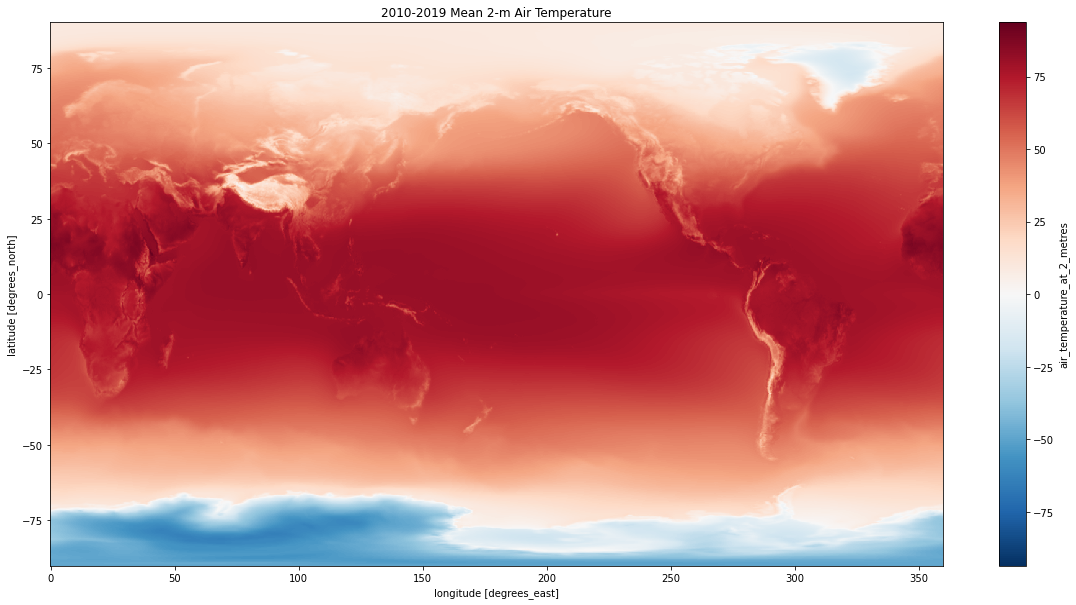

In [12]:
temp_mean.plot(figsize=(20, 10))
plt.title('2010-2019 Mean 2-m Air Temperature')

### Repeat for standard deviation

In [13]:
temp_std = ds['air_temperature_at_2_metres'].std(dim='time0')

In [14]:
%time temp_std = temp_std.compute()

CPU times: user 4.66 s, sys: 681 ms, total: 5.34 s
Wall time: 36min 42s


Text(0.5, 1.0, '2010-2019 Standard Deviation 2-m Air Temperature')

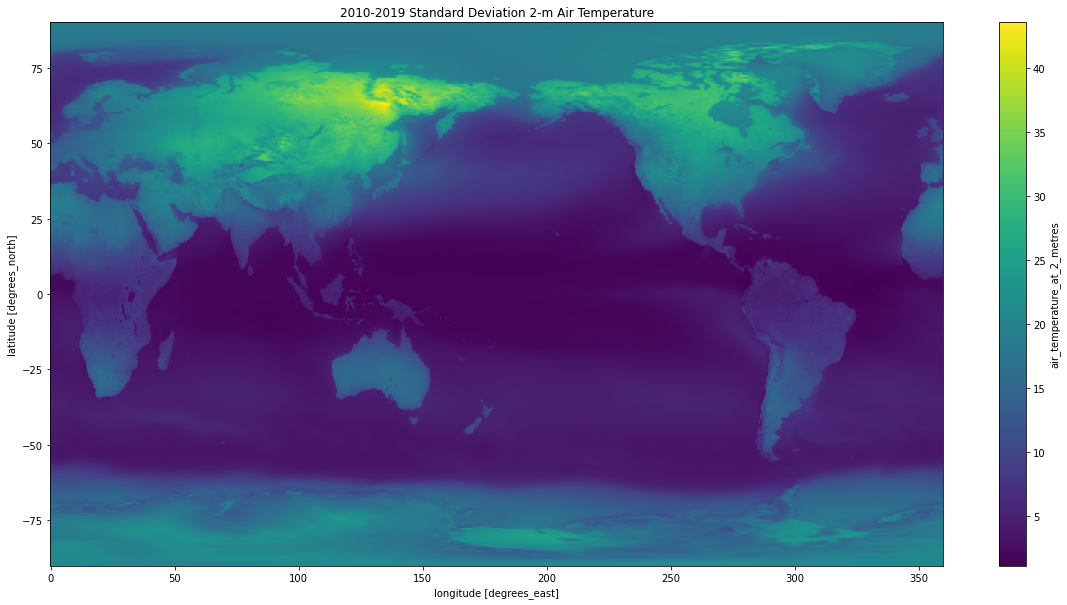

In [15]:
temp_std.plot(figsize=(20, 10))
plt.title('2010-2019 Standard Deviation 2-m Air Temperature')

## Plot temperature time series for points

In [16]:
# location coordinates
locs = [
    {'name': 'Santa Barbara', 'lon': -119.70, 'lat': 34.42},
    {'name': 'Colorado Springs', 'lon': -104.82, 'lat': 38.83},
    {'name': 'Honolulu', 'lon': -157.84, 'lat': 21.29},
    {'name': 'Seattle', 'lon': -122.33, 'lat': 47.61},
]

# convert westward longitudes to degrees east
for l in locs:
    if l['lon'] < 0:
        l['lon'] = 360 + l['lon']
locs

[{'name': 'Santa Barbara', 'lon': 240.3, 'lat': 34.42},
 {'name': 'Colorado Springs', 'lon': 255.18, 'lat': 38.83},
 {'name': 'Honolulu', 'lon': 202.16, 'lat': 21.29},
 {'name': 'Seattle', 'lon': 237.67000000000002, 'lat': 47.61}]

In [17]:
ds_locs = xr.Dataset()
air_temp_ds = ds

# interate through the locations and create a dataset
# containing the temperature values for each location
for l in locs:
    name = l['name']
    lon = l['lon']
    lat = l['lat']
    var_name = name

    ds2 = air_temp_ds.sel(lon=lon, lat=lat, method='nearest')

    lon_attr = '%s_lon' % name
    lat_attr = '%s_lat' % name

    ds2.attrs[lon_attr] = ds2.lon.values.tolist()
    ds2.attrs[lat_attr] = ds2.lat.values.tolist()
    ds2 = ds2.rename({'air_temperature_at_2_metres' : var_name}).drop(('lat', 'lon'))

    ds_locs = xr.merge([ds_locs, ds2])

ds_locs.data_vars

Data variables:
    Santa Barbara     (time0) float32 dask.array<chunksize=(720,), meta=np.ndarray>
    Colorado Springs  (time0) float32 dask.array<chunksize=(720,), meta=np.ndarray>
    Honolulu          (time0) float32 dask.array<chunksize=(720,), meta=np.ndarray>
    Seattle           (time0) float32 dask.array<chunksize=(720,), meta=np.ndarray>

### Convert to dataframe

In [18]:
df_f = ds_locs.to_dataframe()
df_f.describe()

,Santa Barbara,Colorado Springs,Honolulu,Seattle
count,87648.000000,87648.000000,87648.000000,87648.000000
mean,61.090996,47.680191,75.612930,52.841934
std,9.689262,20.055971,2.627288,11.063382
min,34.992512,-16.082489,62.667511,14.067511
25%,53.780010,32.067513,73.805008,44.780010
50%,61.092510,47.817513,75.605011,52.092510
75%,68.180008,62.442513,77.517509,60.417511
max,96.417511,98.330009,83.817513,91.692513


## Plot January temperatures

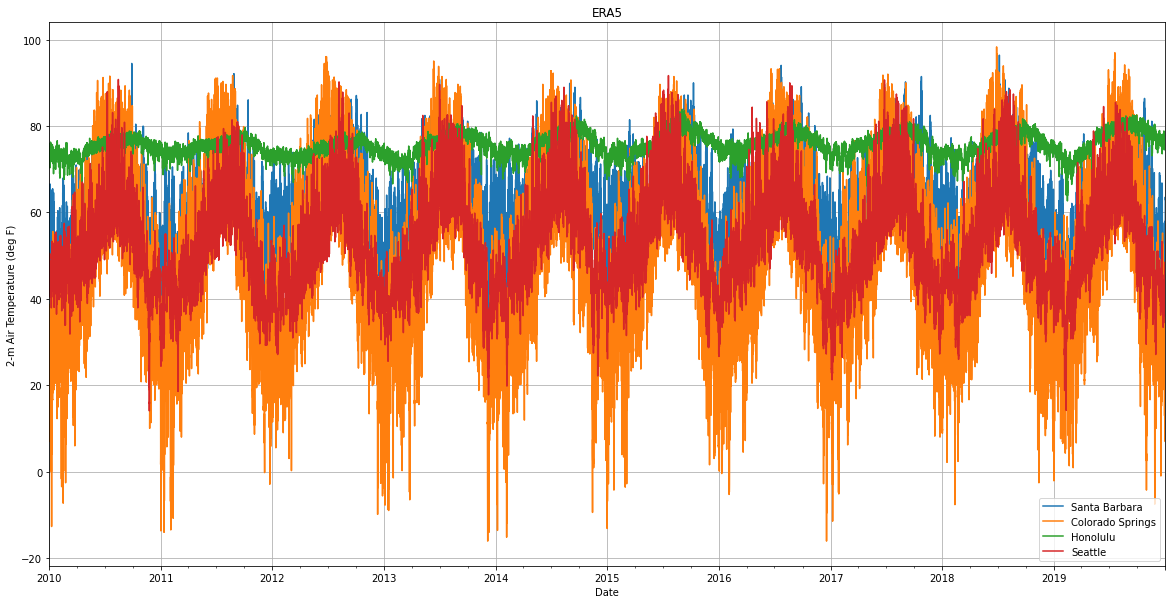

In [19]:
ax = df_f.plot(figsize=(20, 10), title="ERA5", grid=1)
ax.set(xlabel='Date', ylabel='2-m Air Temperature (deg F)')
plt.show()

## Cluster scale down

When we are temporarily done with the cluster we can scale it down to save on costs

In [20]:
numWorkers=0
ecs.update_service(cluster=cluster, service='Dask-Worker', desiredCount=numWorkers)
ecs.get_waiter('services_stable').wait(cluster=cluster, services=['Dask-Worker'])